[INFO] loading images...
C:\Users\SHREESH\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[INFO] compiling model...
[INFO] training head...
C:\Users\SHREESH\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/20
95/95 [==============================] - 92s 928ms/step - loss: 0.4647 - accuracy: 0.8309 - val_loss: 0.1851 - val_accuracy: 0.9883
Epoch 2/20
95/95 [==============================] - 84s 883ms/step - loss: 0.1739 - accuracy: 0.9539 - val_loss: 0.0871 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 85s 889ms/step - loss: 0.1068 - accuracy: 0.9753 - val_loss: 0.0602 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 83s 871ms/s

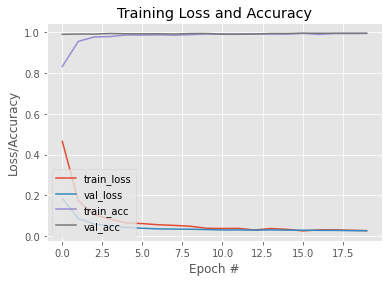

In [3]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"D:\Face-Mask-Detection-1-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [5]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import imutils
import time
import cv2
import os

from tensorflow.python.framework.ops import container

#This fuctions detects people with mask and no mask 
#Following program inlclude many prewritten part like accuracy filter
def detectmask(frame, capface, capmask):

	(height, width) = frame.shape[:2]
	container = cv2.dnn.blobFromImage(frame, 1.0, (500, 500),
		(104.0, 177.0, 123.0))

	# container will go through all and get face detections
	capface.setInput(container)
	detections = capface.forward()
	print(detections.shape)


	totalface = []
	locations = []
	counts = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		
		accuracy = detections[0, 0, i, 2]

		# remove low accuracy detections
		if accuracy > 0.5:
			
			boundary = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
			(X1, Y1, X2, Y2) = boundary.astype("int")

			
			(X1, Y1) = (max(0, X1), max(0, Y1))
			(X2, Y2) = (min(width - 1, X2), min(height - 1, Y2))

			# convert BGR to RGB
			face = frame[Y1:Y2, X1:X2]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (450, 450))
			face = img_to_array(face)
			face = preprocess_input(face)

			
			totalface.append(face)
			locations.append((X1, Y1, X2, Y2))

	# if only one face is detected
	if len(totalface) > 0:
		totalface = np.array(totalface, dtype="float32")
		counts = capmask.predict(totalface, batch_size=32)

	return (locations, counts)

# using a prewritten script that is face detector model from local storage
prototxtPath = r"detection_facemask\deploy.prototxt"
weightsPath = r"detection_facemask\res10_300x300_ssd_iter_140000.caffemodel"
capface = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the the script from local storage
capmask = load_model("mask_detector.model")

# video capturing
print("starting capturing faces")
vs = VideoStream(src=0).start()

while True:
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect face
	(locations, counts) = detectmask(frame, capface, capmask)

	for (boundary, count) in zip(locations, counts):
		(X1, Y1, X2, Y2) = boundary
		(mask, withoutMask) = count

		header = "Mask" if mask > withoutMask else "No Mask get a mask stupid do you wanna get infected"
		

		header = "{}: {:.2f}%".format(header, max(mask, withoutMask) * 100)

		color = (0, 255, 0) if header == "Mask" else (0, 0, 255)

		# frame
		cv2.putText(frame, header, (X1, Y1 - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		#creating rectangular face detecter
		cv2.rectangle(frame, (X1, Y1), (X2, Y2), color, 2)

	# display
	cv2.imshow("Detector", frame)
	key = cv2.waitKey(1) & 0xFF

	# for closing the applications
	if key == ord("q"):
		break

cv2.destroyAllWindows()
vs.stop()

starting capturing faces
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
